In [ ]:
cd /content/drive/MyDrive/DS2

/content/drive/MyDrive/DS2


In [ ]:
!pip3 install vncorenlp

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

In [ ]:
import pandas as pd
from tqdm import tqdm

In [ ]:
!pip install transformers

In [ ]:
import torch
device = 'cuda'
from transformers import AutoModel, AutoTokenizer

phobert = AutoModel.from_pretrained("vinai/phobert-base").to(device)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
tokenizer_phobert = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 


# Load data

In [ ]:
data = pd.read_csv('./dataset/Preprocessed_data.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Split sentences and add end token

In [ ]:
for x in tqdm(range(data.shape[0])):
  sentences = rdrsegmenter.tokenize(data.description.iloc[x])
  tmp = []
  for sentence in sentences:
      arr = " ".join(sentence)
      tmp.append(arr)
  data.loc[x,'des_tokens'] = ' </s> <s> '.join(tmp)

100%|██████████| 65135/65135 [09:21<00:00, 116.05it/s]


In [ ]:
data.head(3)

,description,origin,status,car_mileage,car_color,car_seats,gear,car_year,car_price,style,model,fuel,brand_name,region_name,url_image,website,month,year,num_null,des_tokens
0,🔹 HÀNG MỚI VỀ\n🔹 BMW 520i \n🔹 MODEL 2016\n🔹 Od...,Đức,Đã sử dụng,50000.0,Đen,4.0,Tự động,2015.0,1.170000e+09,Sedan,5 Series,Xăng,BMW,Hà Nội,https://cdn.chotot.com/namB6E0XkDPkf9h8KoahoRB...,chotot,11,2021,0,🔹 HÀNG MỚI VỀ 🔹 BMW 520i 🔹 MODEL 2016 🔹 Odo : ...
1,Bán nissan - Gran Livina nhập khẩu số tự động ...,Nhật Bản,Đã sử dụng,12000.0,Xám,3.0,Tự động,2009.0,2.342500e+08,Minivan (MPV),Grand livina,Xăng,Nissan,Hà Nội,https://cdn.chotot.com/50R_cYWFPAz0wHZqPAGaFr-...,chotot,11,2021,0,Bán nissan - Gran_Livina nhập_khẩu số tự_động ...
2,Auto88 về Mercedes C200 sx 2017 đky 2/2018 chạ...,Việt Nam,Đã sử dụng,30000.0,Xám,2.0,Tự động,2018.0,1.090000e+09,Sedan,C Class,Xăng,Mercedes Benz,Hà Nội,https://cdn.chotot.com/bhfeL3dPtccDnzlKzeAZ88X...,chotot,11,2021,0,Auto88 về Mercedes C200 sx 2017 đky 2/2018 chạ...


In [ ]:
cols = ['des_tokens']
new_data = pd.DataFrame(data[cols])

In [ ]:
new_data.to_csv('./dataset/pre_new_des.csv',index=False)

In [ ]:
new_data = pd.read_csv('./dataset/pre_new_des.csv')

# Analyze the number of sentences

In [ ]:
lenDes = []
for x in tqdm(range(new_data.shape[0])):
    arr = new_data.des_tokens.iloc[x].split(' ')
    lenDes.append(len(arr))

100%|██████████| 65135/65135 [00:01<00:00, 34740.67it/s]


(array([3.6837e+04, 1.9159e+04, 5.6220e+03, 2.0950e+03, 1.1100e+03,
        2.5600e+02, 4.0000e+01, 1.4000e+01, 0.0000e+00, 2.0000e+00]),
 array([  6. ,  74.4, 142.8, 211.2, 279.6, 348. , 416.4, 484.8, 553.2,
        621.6, 690. ]),
 <a list of 10 Patch objects>)

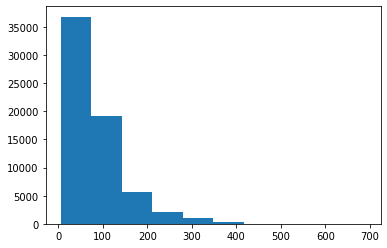

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lenDes,10)

# Word Embedding

In [ ]:
def converInput(newData):
    train_ids = []
    train_token = []
    train_mask = []
    for x in tqdm(range(newData.shape[0])):
        input = tokenizer_phobert.encode_plus(newData.iloc[x]['des_tokens'],padding ='max_length',max_length=150,truncation =True)
        train_ids.append(input['input_ids'])
        train_token.append(input['token_type_ids'])
        train_mask.append(input['attention_mask'])
    return train_ids,train_token,train_mask

In [ ]:
train_ids,train_token,train_mask = converInput(new_data)

100%|██████████| 65135/65135 [01:07<00:00, 968.11it/s] 


In [ ]:
train_ids = torch.tensor(train_ids)
train_token = torch.tensor(train_token)
train_mask = torch.tensor(train_mask)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
train_data = TensorDataset(train_ids, train_token,train_mask)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=16)
torch.save(train_dataloader,'./dataset/train_dataloader')

In [ ]:
train_dataloader = torch.load('./dataset/train_dataloader')

In [ ]:
df = []
phobert.train()
with torch.no_grad():
  for x, batch in tqdm(enumerate(train_dataloader)):
      train_ids = batch[0].to(device)
      train_tokens = batch[1].to(device)
      train_mask = batch[2].to(device)
      encoded_layers = phobert(train_ids, token_type_ids = train_tokens, attention_mask =train_mask)
      top_vec = encoded_layers[0]
      top_vec = top_vec[:,0,:].cpu()
      df.append(top_vec)

4071it [20:01,  3.39it/s]


In [ ]:
tmp = torch.concat(df)

# Export vector to storage

In [ ]:
torch.save(tmp,'./dataset/featureDes')